## Imports

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from numba import njit
from sklearn.metrics import r2_score
%matplotlib inline
plt.style.use('ggplot')

## Global Settings

In [55]:
OUTPUT_DIR = 'output'
C_m_Farad = 3300E-12
f_Hz = 9600.0
device_length_meters = 0.0981
FILENAME_TEMPLATE = 'testdata/ALL{caseNum:04d}.CSV'
skipRowNum = 25
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Data Loading & Processing Functions

In [56]:
def load_data_and_metadata(filename):
    metadata = {}
    keys_to_extract = ['Memory Length', 'Sampling Period', 'Trigger Address', 'Horizontal Scale']
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            for i, row in enumerate(reader):
                if i >= skipRowNum: break
                if not row: continue
                if row[0] in keys_to_extract and row[0] not in metadata:
                    metadata[row[0]] = row[1]
        meta_typed = {
            'MEMORY_LENGTH': int(metadata['Memory Length']),
            'SAMPLING_PERIOD': float(metadata['Sampling Period']),
            'TRIGGER_ADDRESS': int(metadata['Trigger Address']),
            'HORIZONTAL_SCALE': float(metadata['Horizontal Scale'])
        }
        df = pd.read_csv(filename, skiprows=skipRowNum, header=None, usecols=[1, 3], names=['CH1', 'CH2'])
        return meta_typed, df['CH1'].to_numpy(), df['CH2'].to_numpy()
    except Exception as e:
        print(f'Error loading {filename}: {e}')
        return None, None, None

def calculate_time_axis(metadata):
    idx = np.arange(metadata['MEMORY_LENGTH'])
    time = (idx - metadata['TRIGGER_ADDRESS']) * metadata['SAMPLING_PERIOD']
    return time * 1000

def calculate_ac_components(ch1, ch2):
    return ch1 - np.mean(ch1), ch2 - np.mean(ch2)

## Plotting Functions

In [57]:
def plot_waveforms(time_ms, ch1, ch2, h_scale, case_num, output_dir):
    case_dir = os.path.join(output_dir, f'Case_{case_num}')
    os.makedirs(case_dir, exist_ok=True)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(time_ms, ch1, 'b', label='CH1', alpha=0.9)
    ax1.set_xlabel('Time [ms]'); ax1.set_ylabel('CH1 [V]', color='b')
    ax1.tick_params(axis='y', labelcolor='b'); ax1.grid(True, linestyle='--', alpha=0.6)
    ax2 = ax1.twinx()
    ax2.plot(time_ms, ch2, 'r', label='CH2', alpha=0.9)
    ax2.set_ylabel('CH2 [V]', color='r'); ax2.tick_params(axis='y', labelcolor='r')
    fig.suptitle(f'Waveform - Case {case_num}')
    fig.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(case_dir, f'Waveform_Full_Case_{case_num}.png'))
    plt.show()
    zoom_range = 5 * h_scale * 1000
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time_ms, ch1, 'b', label='CH1')
    ax2 = ax.twinx()
    ax2.plot(time_ms, ch2, 'r', label='CH2')
    ax.set_xlim(-zoom_range, zoom_range)
    ax.set_xlabel('Time [ms]'); ax.set_ylabel('CH1 [V]', color='b')
    ax2.set_ylabel('CH2 [V]', color='r')
    fig.suptitle(f'Zoom Waveform - Case {case_num}')
    plt.tight_layout()
    plt.savefig(os.path.join(case_dir, f'Waveform_Zoom_Case_{case_num}.png'))
    plt.show()

def plot_lissajous(ch1_ac, ch2_ac, case_num, output_dir):
    case_dir = os.path.join(output_dir, f'Case_{case_num}')
    os.makedirs(case_dir, exist_ok=True)
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.plot(ch1_ac, ch2_ac, color='navy', linewidth=0.5)
    ax.set_title(f'Lissajous - Case {case_num}')
    ax.set_xlabel('CH1 (V)'); ax.set_ylabel('CH2 (Q)')
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.axhline(0, color='k', ls='--', lw=0.5); ax.axvline(0, color='k', ls='--', lw=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(case_dir, f'Lissajous_Case_{case_num}.png'), dpi=150)
    plt.show()

@njit(fastmath=True, cache=True)
def shoelace_area(x, y):
    n = len(x)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += (x[i] * y[j])
        area -= (x[j] * y[i])
    return 0.5 * np.abs(area)

def calculate_power(ch1_ac, ch2_ac, c_m, metadata, case_num):
    area = shoelace_area(ch1_ac, ch2_ac)
    energy = area * c_m
    total_time = metadata['MEMORY_LENGTH'] * metadata['SAMPLING_PERIOD']
    power = energy / total_time
    print(f'Case {case_num}: Power = {power:.4f} W, Area = {area:.2f} V^2')
    return power, area

## Analysis Functions

In [58]:
def analyze_cases(case_numbers, output_dir, c_m, dev_len, plot=True):
    results = []
    for num in case_numbers:
        fname = FILENAME_TEMPLATE.format(caseNum=num)
        if not os.path.exists(fname): continue
        meta, ch1, ch2 = load_data_and_metadata(fname)
        if meta is None: continue
        time_ms = calculate_time_axis(meta)
        ch1_ac, ch2_ac = calculate_ac_components(ch1, ch2)
        vpp = ch1.max() - ch1.min()
        if plot:
            plot_waveforms(time_ms, ch1, ch2, meta['HORIZONTAL_SCALE'], num, output_dir)
            plot_lissajous(ch1_ac, ch2_ac, num, output_dir)
        power, area = calculate_power(ch1_ac, ch2_ac, c_m, meta, num)
        p_density = power / dev_len
        results.append({
            'Case': num,
            'Sampling Period': meta['SAMPLING_PERIOD'],
            'Vpp': vpp,
            'Power': power,
            'Power Density': p_density,
            'Area': area
        })
    return pd.DataFrame(results)

def plot_power_vs_voltage(df, output_dir):
    if df.empty: return
    df = df.sort_values('Vpp')
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(df['Vpp'], df['Power Density'], 'o-', color='blue')
    ax.set_title('Vpp vs Power Density')
    ax.set_xlabel('Vpp [V]'); ax.set_ylabel('Power Density [W/m]')
    ax.grid(True, ls=':')
    for _, row in df.iterrows():
        ax.text(row['Vpp'], row['Power Density'], f"Case {int(row['Case'])}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'Vpp_vs_PowerDensity.png'))
    plt.show()

def plot_sampling_period_comparison(df, output_dir):
    if df.empty: return
    df = df.sort_values('Sampling Period')
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(df['Sampling Period'], df['Power'], 'o-', color='green')
    ax.set_title('Sampling Period vs Power')
    ax.set_xlabel('Sampling Period [s]'); ax.set_ylabel('Power [W]')
    ax.grid(True, ls=':')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'SamplingPeriod_vs_Power.png'))
    plt.show()

def perform_power_law_fit(df, output_dir):
    if df.empty: return
    X = df['Vpp']
    Y = df['Power Density']
    log_X = np.log(X)
    log_Y = np.log(Y)
    params = np.polyfit(log_X, log_Y, 1)
    b = params[0]
    log_a = params[1]
    a = np.exp(log_a)
    X_smooth = np.linspace(X.min(), X.max(), 100)
    Y_fit = a * (X_smooth ** b)
    Y_pred = a * (X ** b)
    r_squared = r2_score(Y, Y_pred)
    print(f'Fit: P = {a:.4e} * V^{b:.4f}, R2 = {r_squared:.4f}')
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(X, Y, color='blue', label='Data')
    ax.plot(X_smooth, Y_fit, 'r--', label=f'Fit (R2={r_squared:.4f})')
    ax.set_title(f'Power Law Fit: b={b:.2f}')
    ax.set_xlabel('Vpp [V]'); ax.set_ylabel('Power Density [W/m]')
    ax.legend(); ax.grid(True, ls=':')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'PowerLaw_Fit.png'))
    plt.show()

## Execution: Cases 1‑4

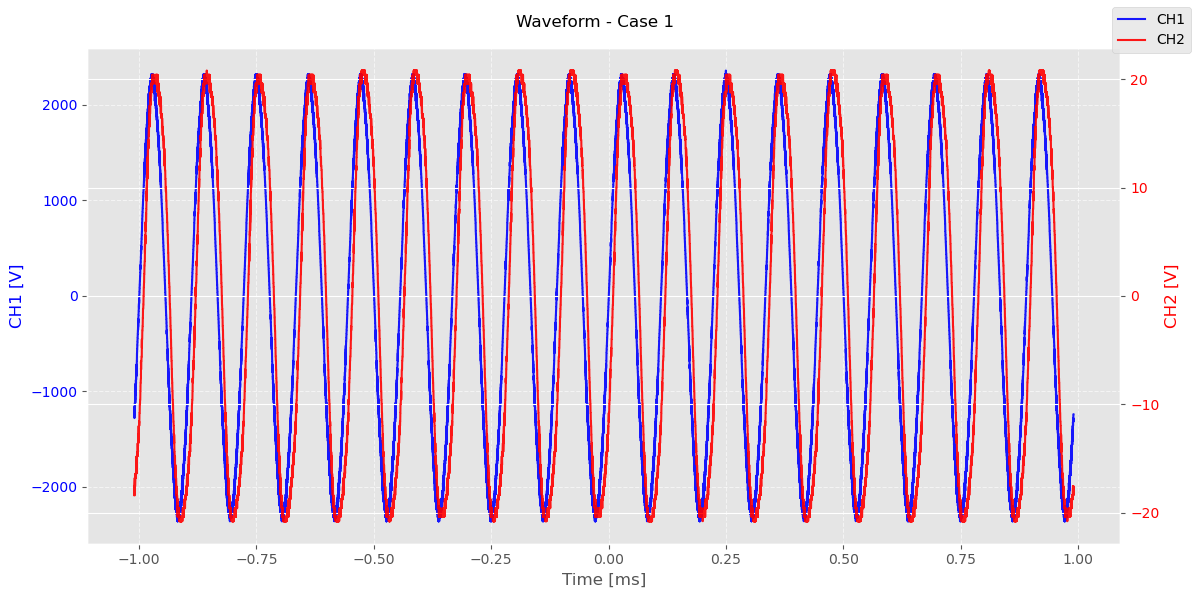

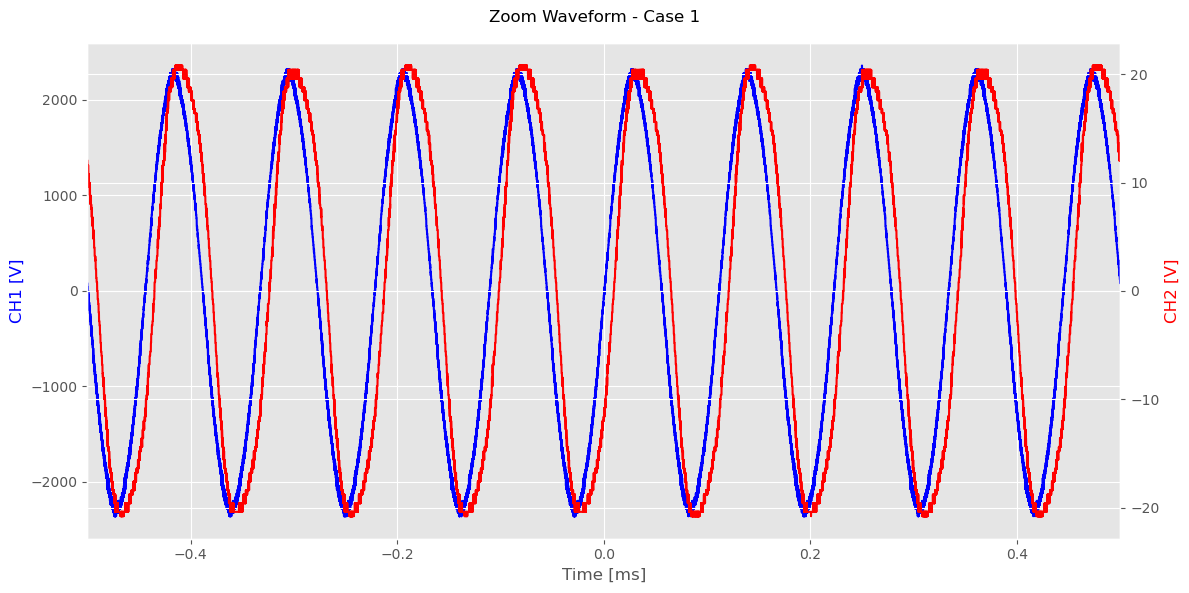

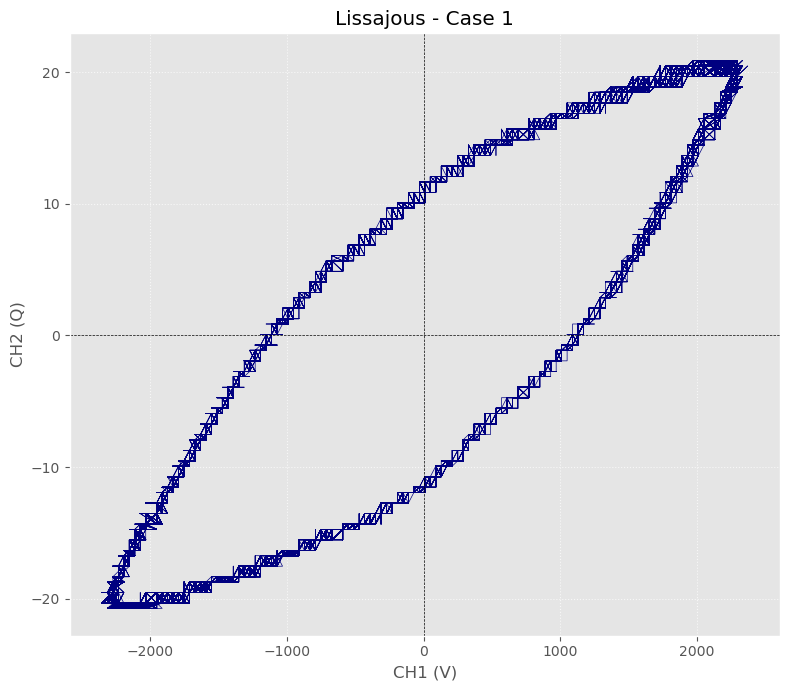

Case 1: Power = 2.1067 W, Area = 1276768.00 V^2


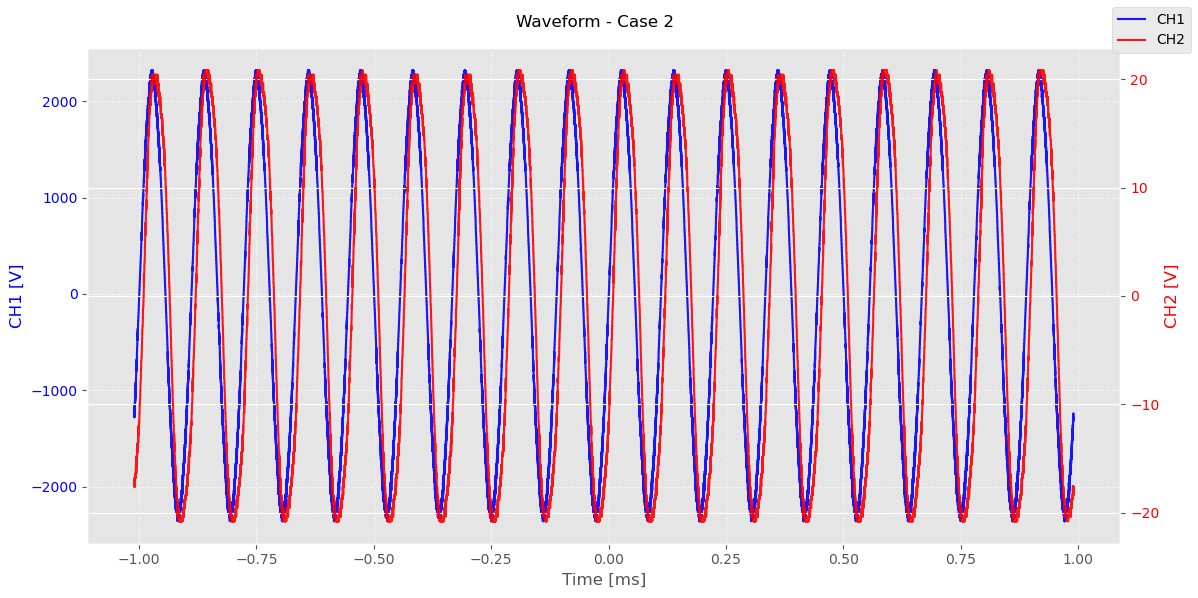

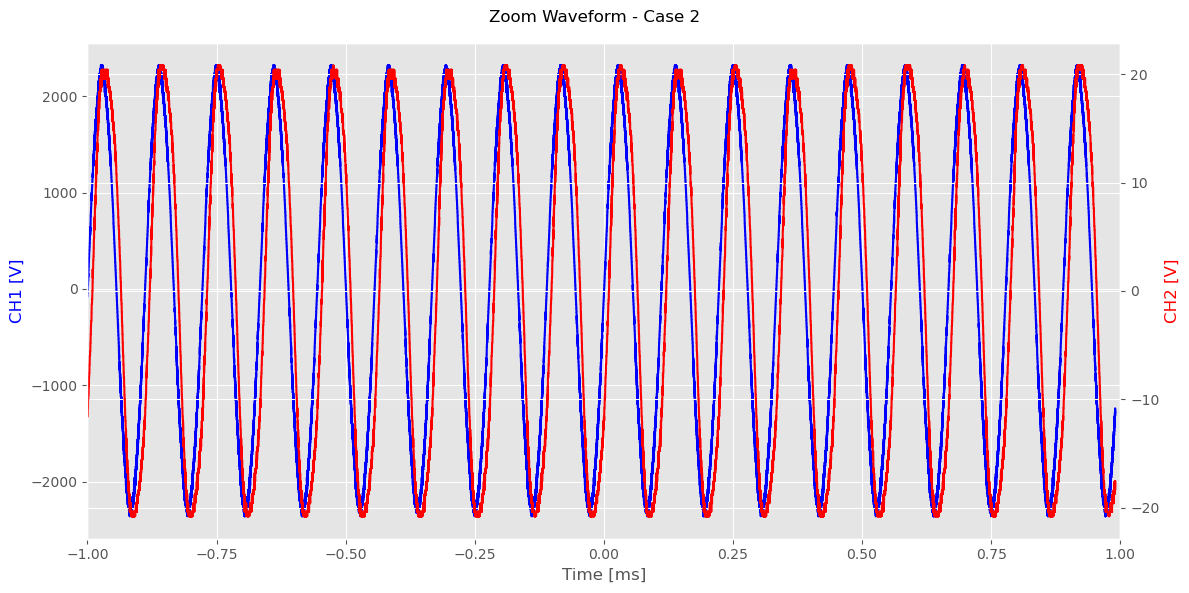

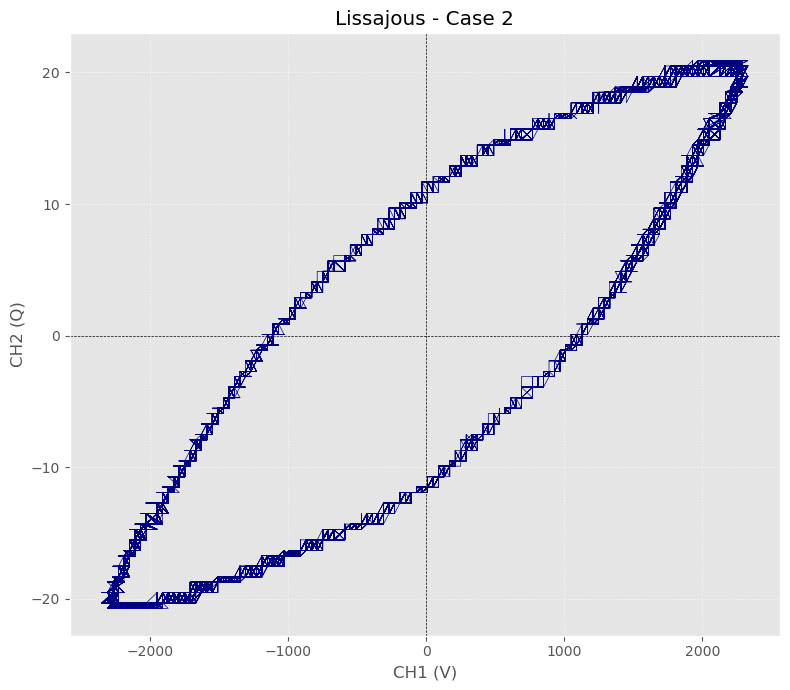

Case 2: Power = 2.1034 W, Area = 1274792.00 V^2


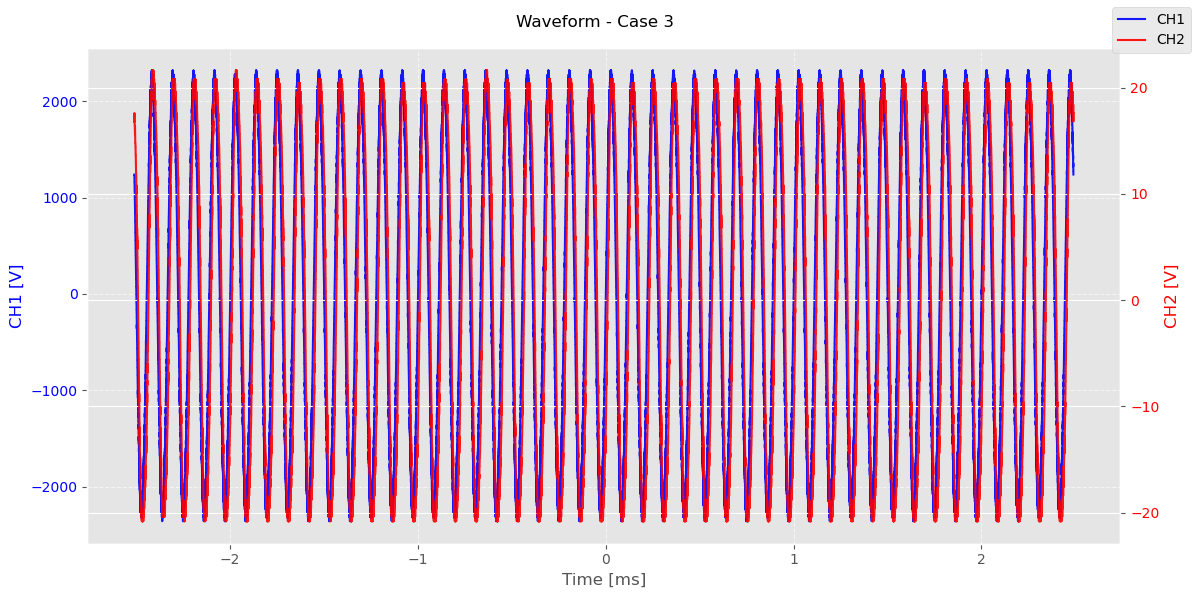

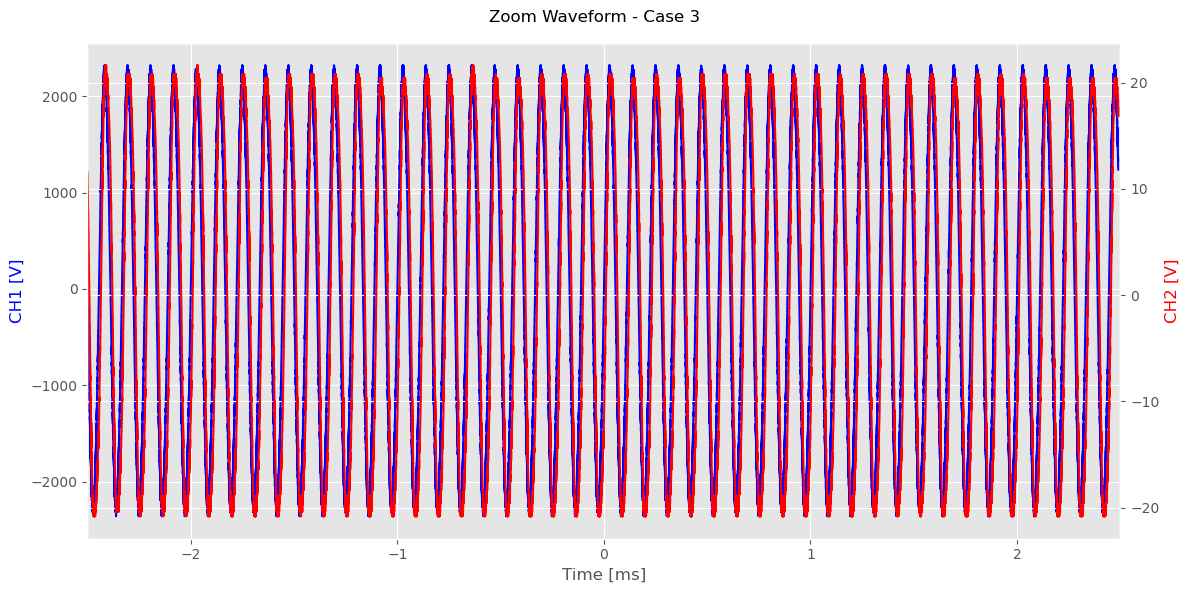

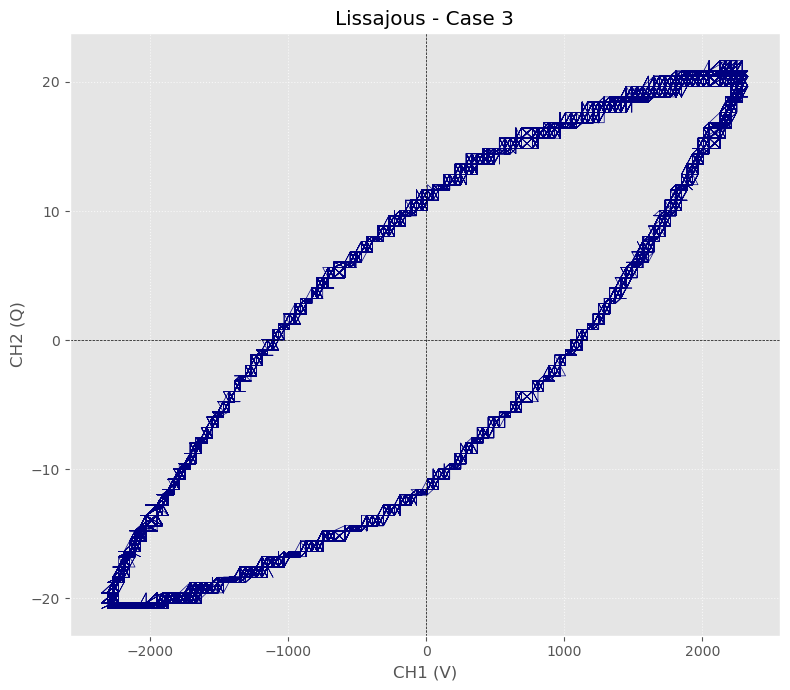

Case 3: Power = 2.0871 W, Area = 3162328.00 V^2


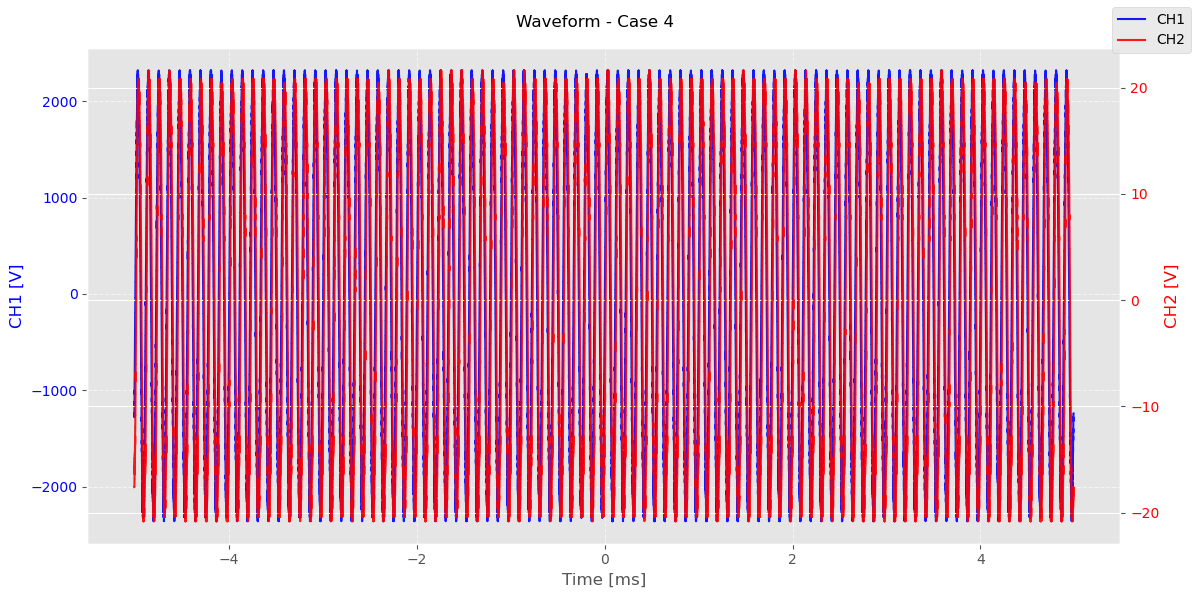

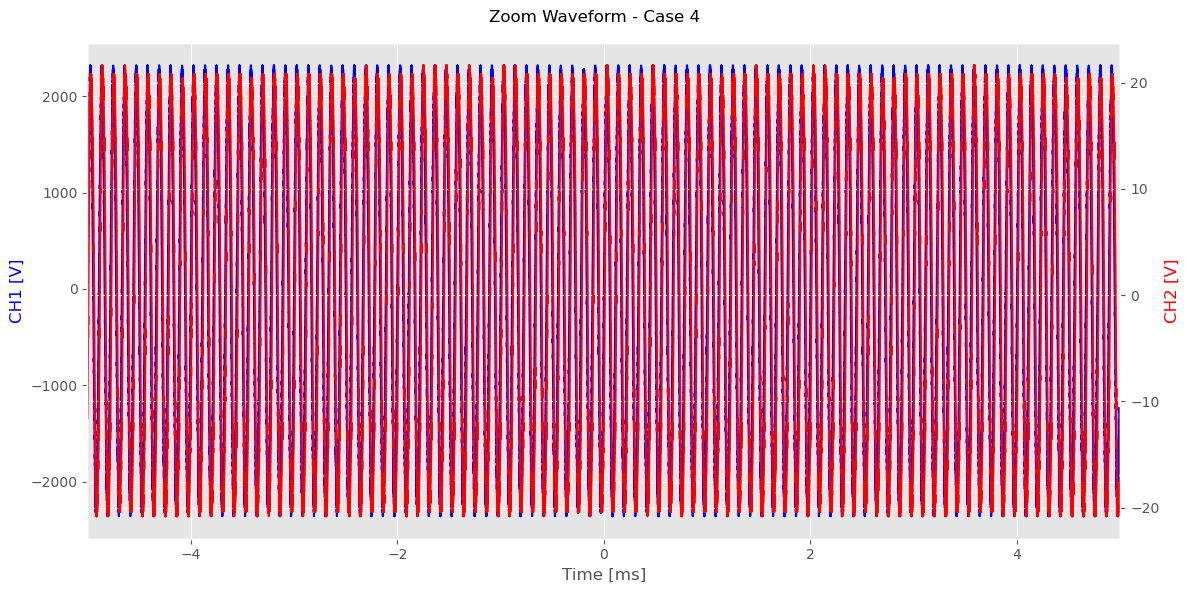

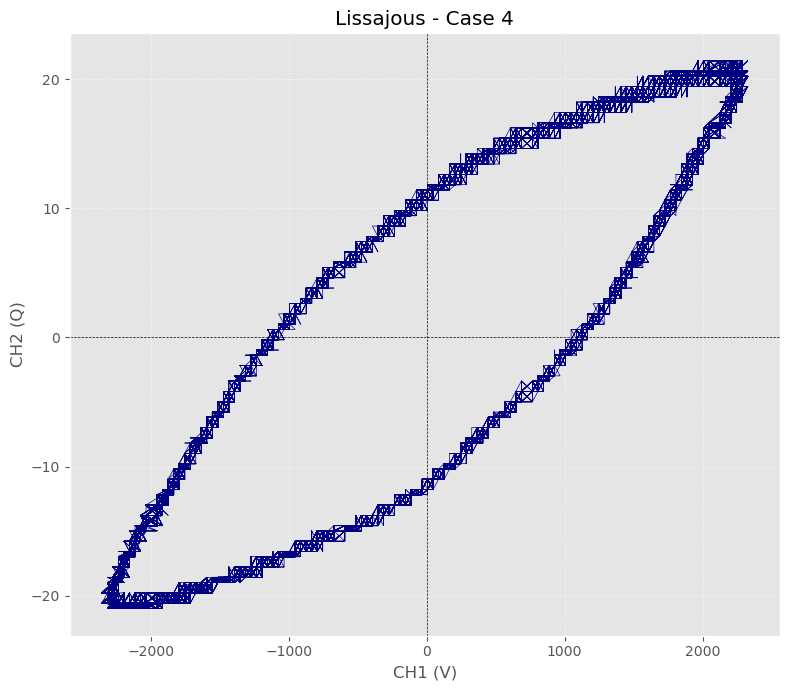

Case 4: Power = 2.0596 W, Area = 6241168.00 V^2


Case  Sampling Period     Vpp     Power  Power Density          Area
0     1     2.000000e-09  4720.0  2.106667      21.474691  1.276768e+06
1     2     2.000000e-09  4680.0  2.103407      21.441456  1.274792e+06
2     3     5.000000e-09  4680.0  2.087136      21.275601  3.162328e+06
3     4     1.000000e-08  4680.0  2.059585      20.994755  6.241168e+06

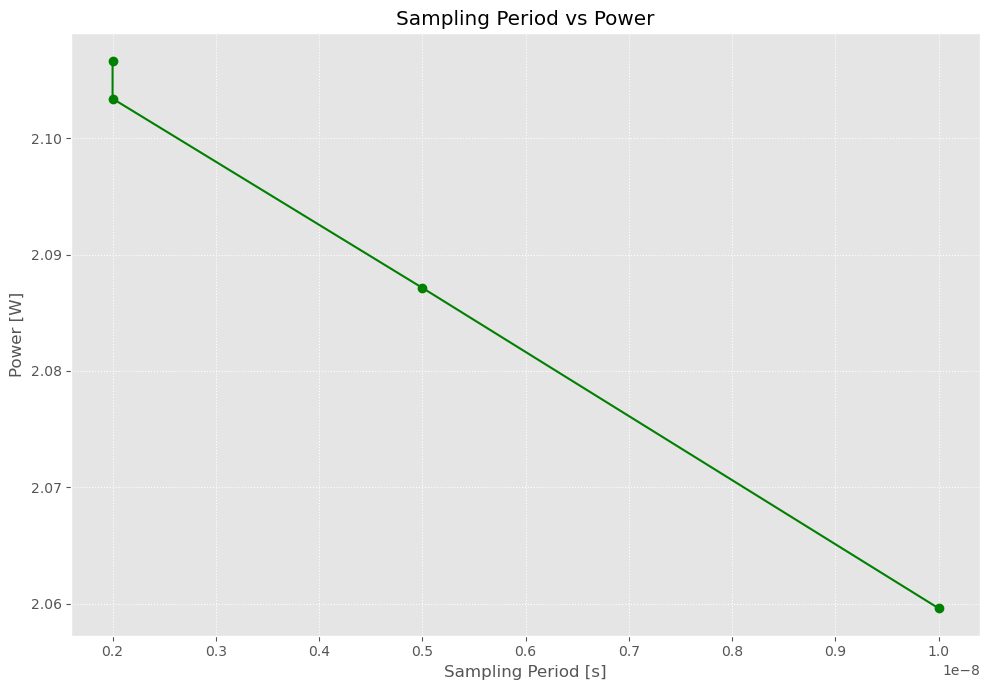

In [59]:
df_1_4 = analyze_cases([1,2,3,4], OUTPUT_DIR, C_m_Farad, device_length_meters)
display(df_1_4)
plot_sampling_period_comparison(df_1_4, OUTPUT_DIR)

## Execution: Cases 6‑10

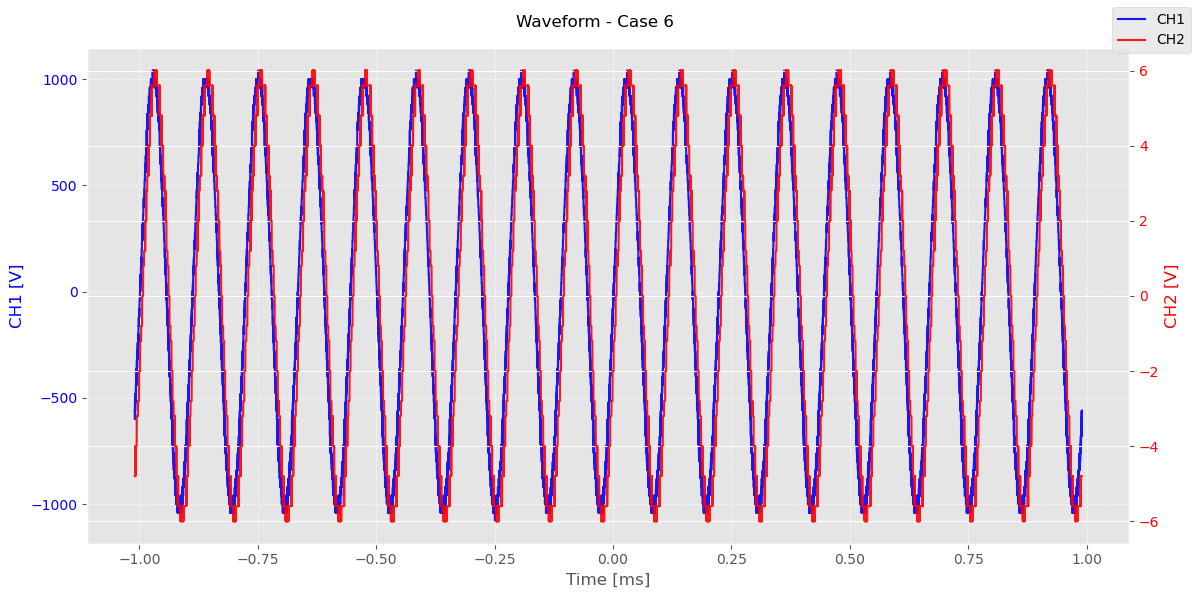

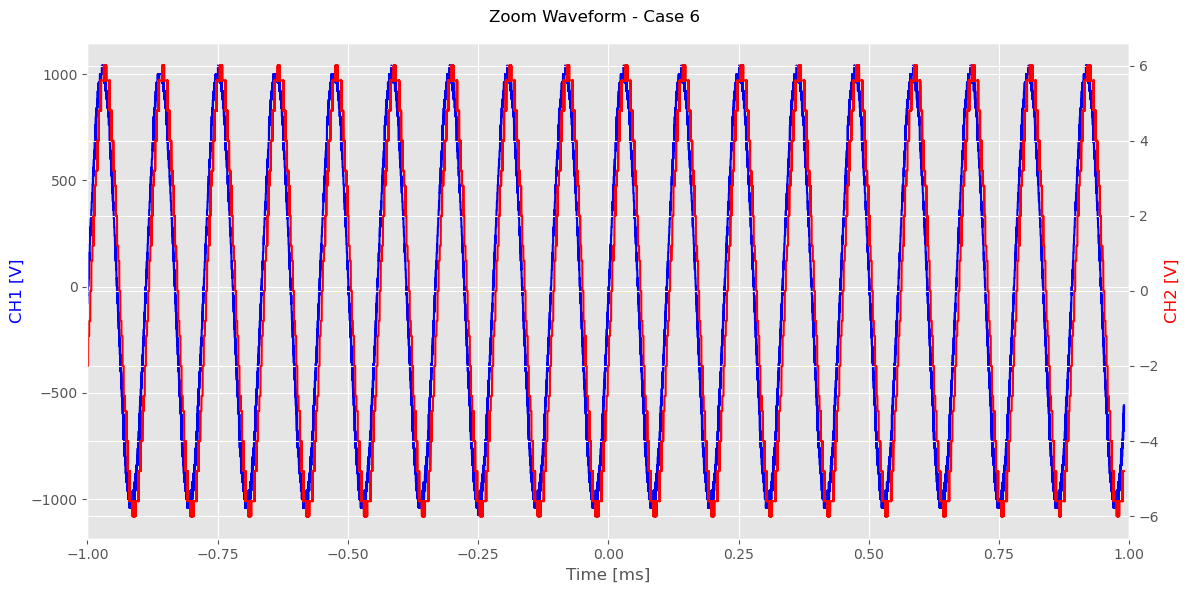

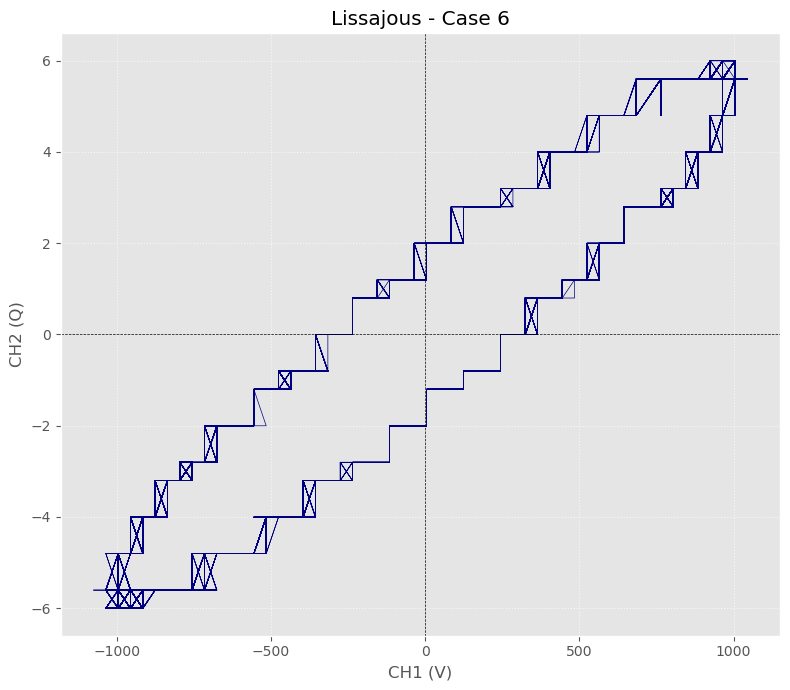

Case 6: Power = 0.1767 W, Area = 107112.00 V^2


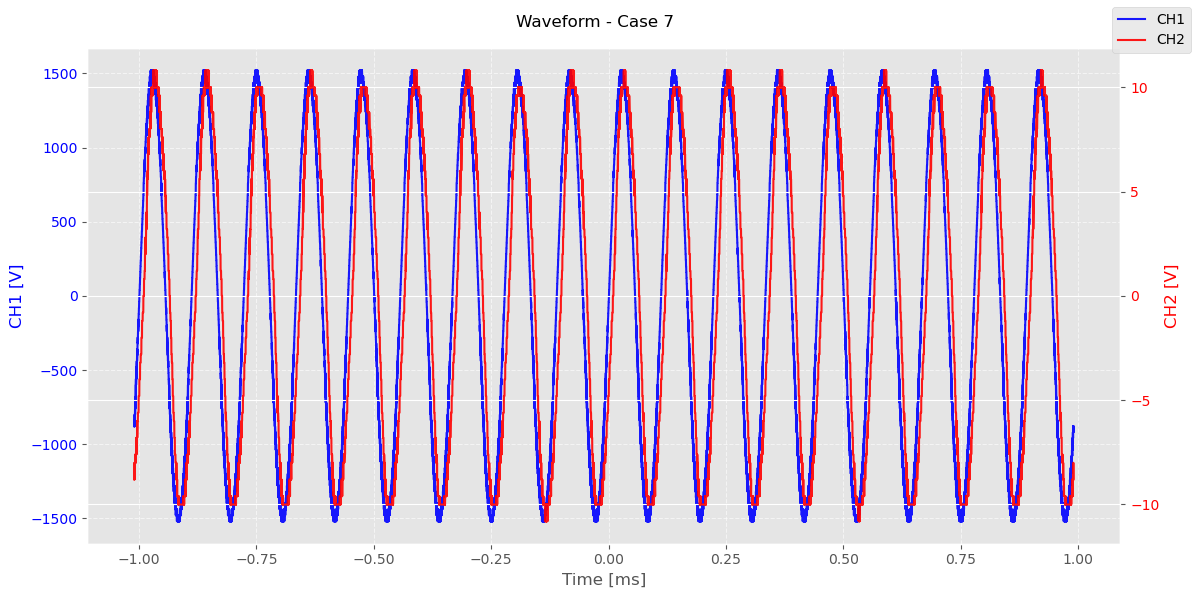

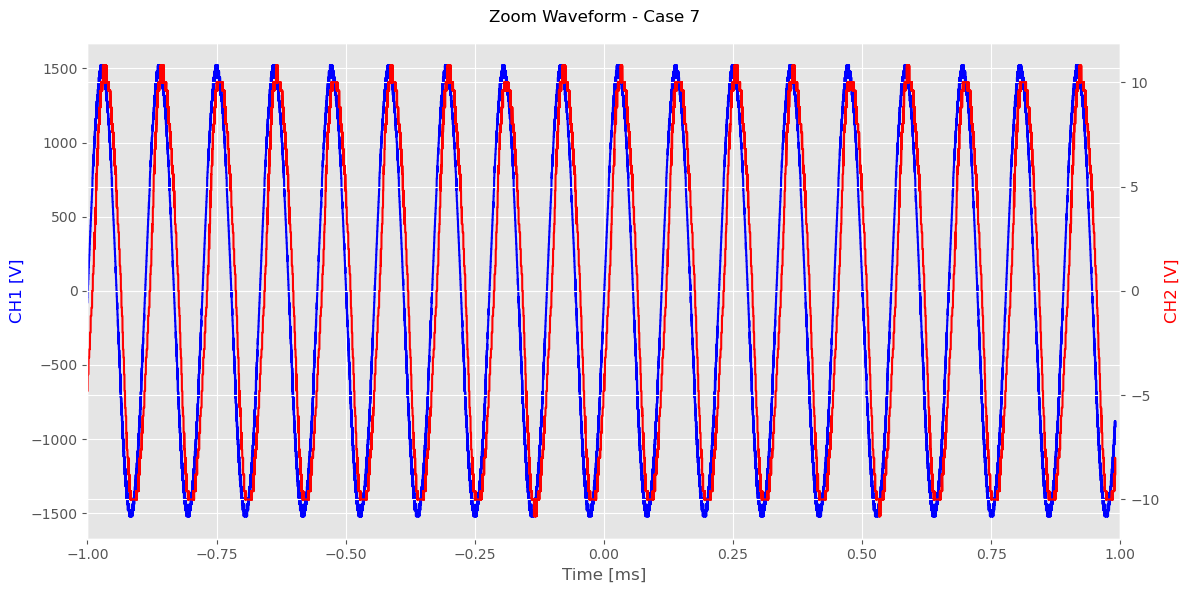

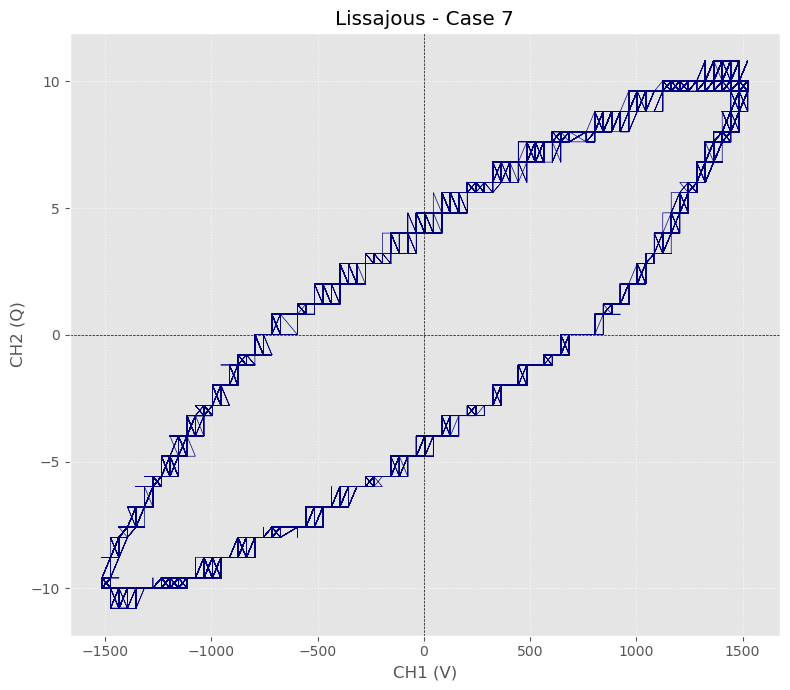

Case 7: Power = 0.6116 W, Area = 370672.00 V^2


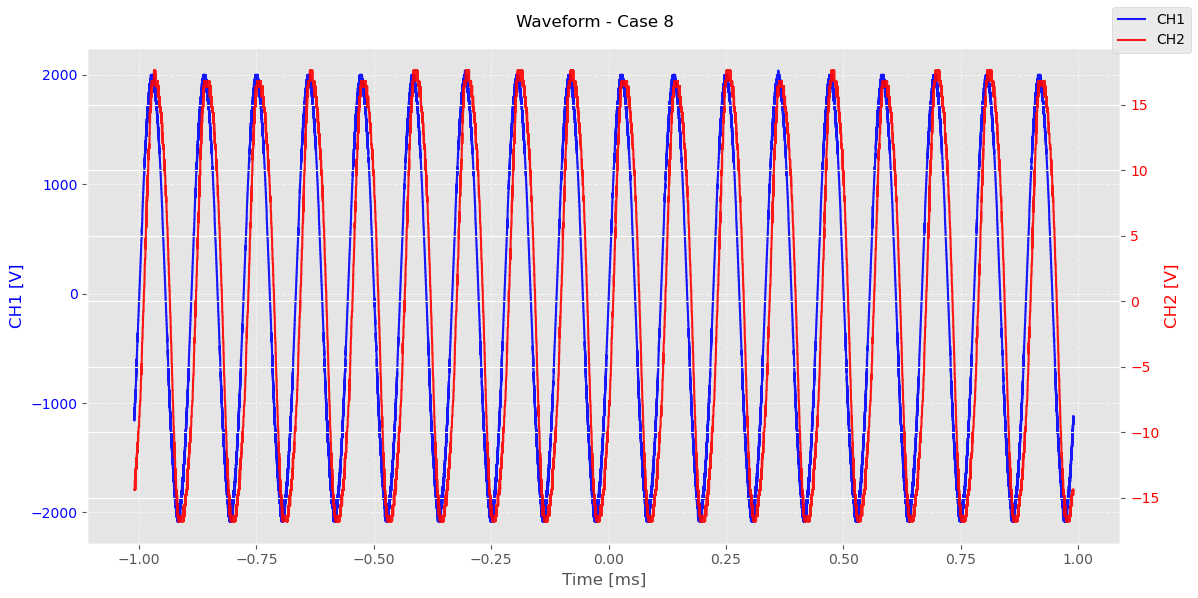

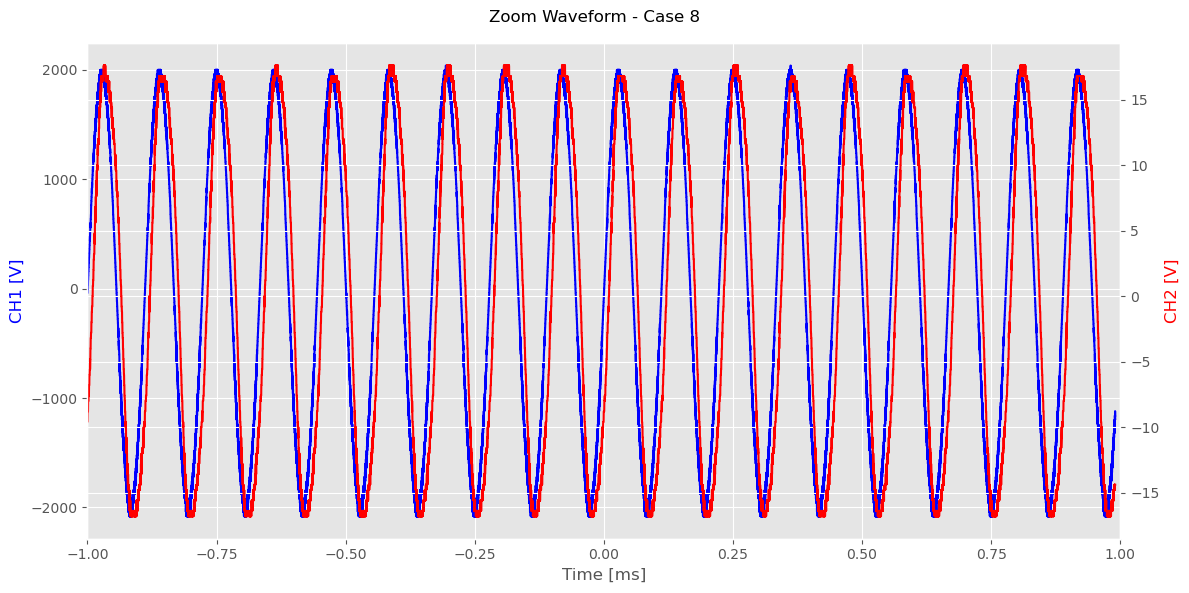

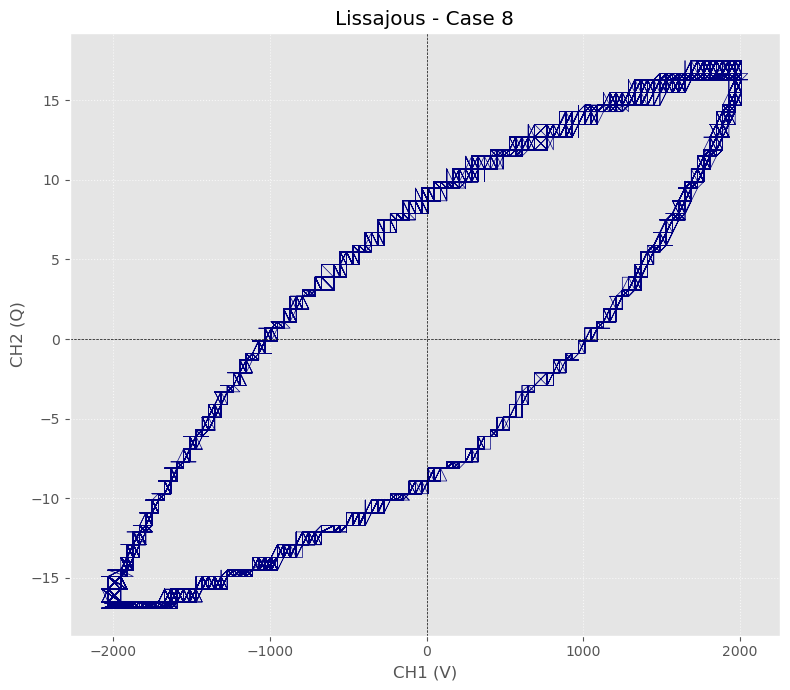

Case 8: Power = 1.5310 W, Area = 927896.00 V^2


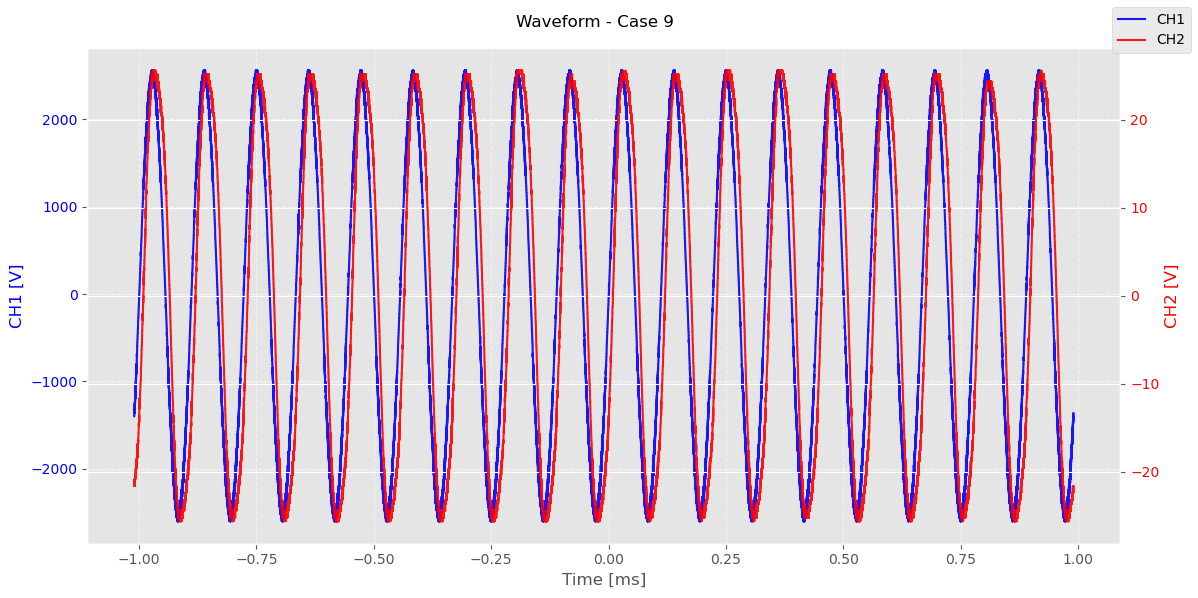

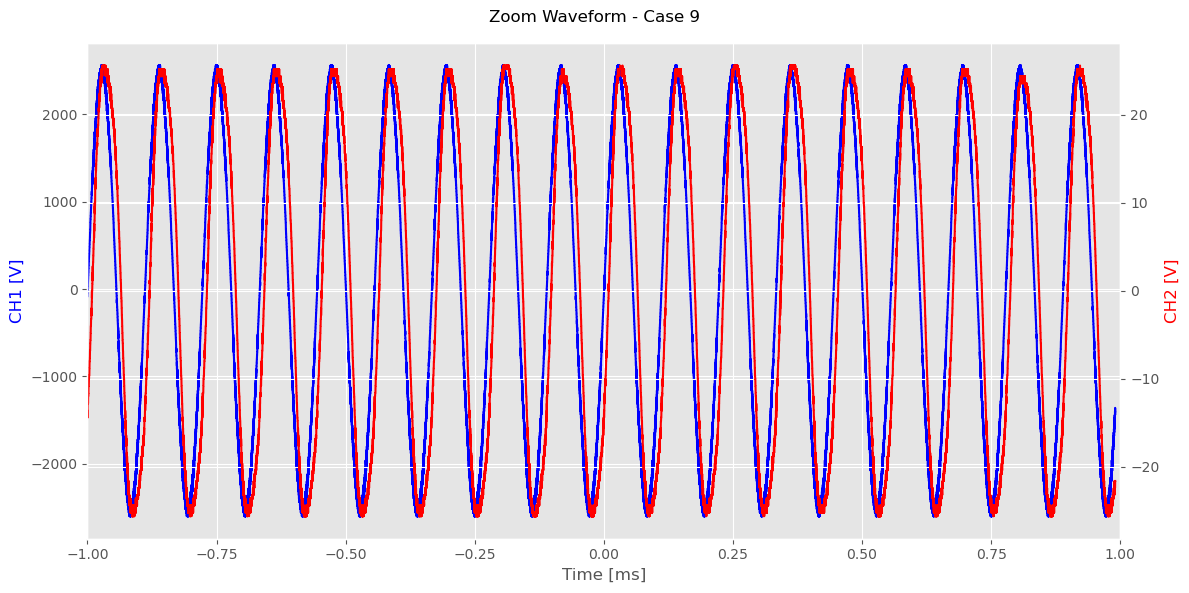

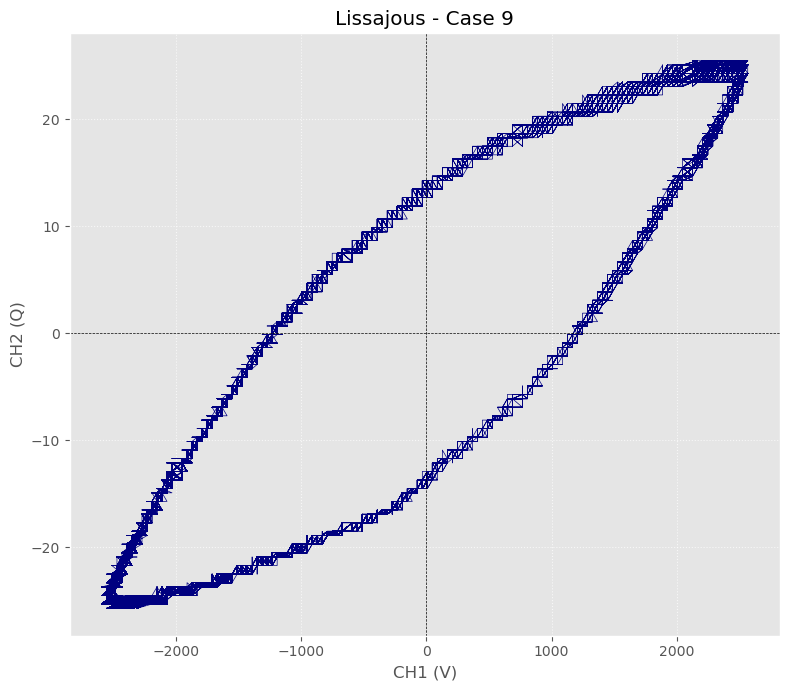

Case 9: Power = 2.7010 W, Area = 1636976.00 V^2


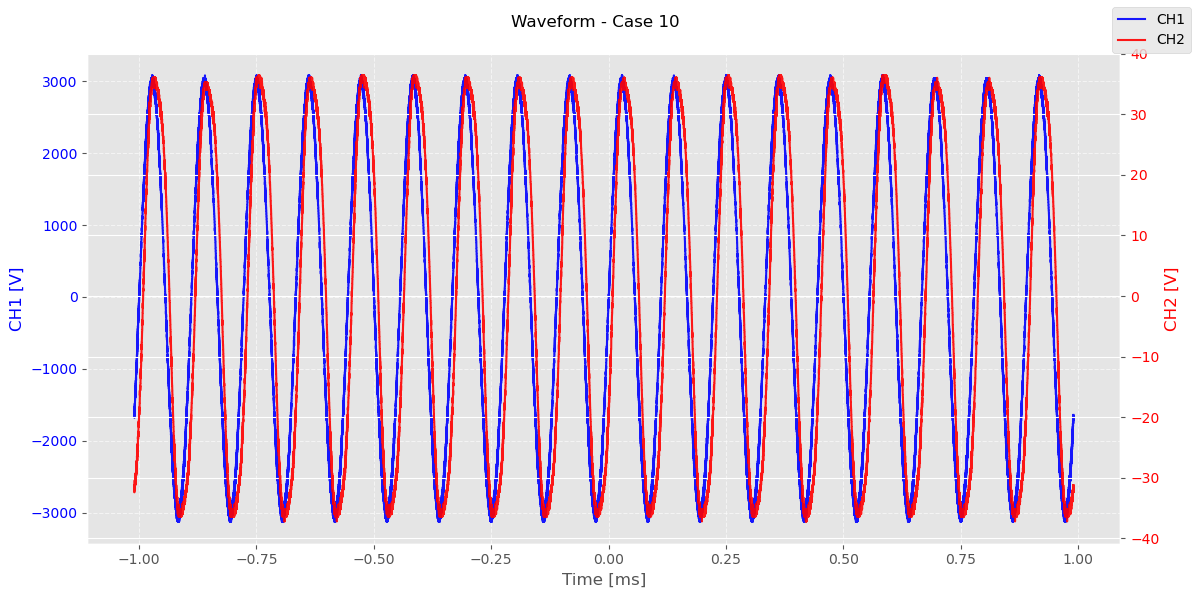

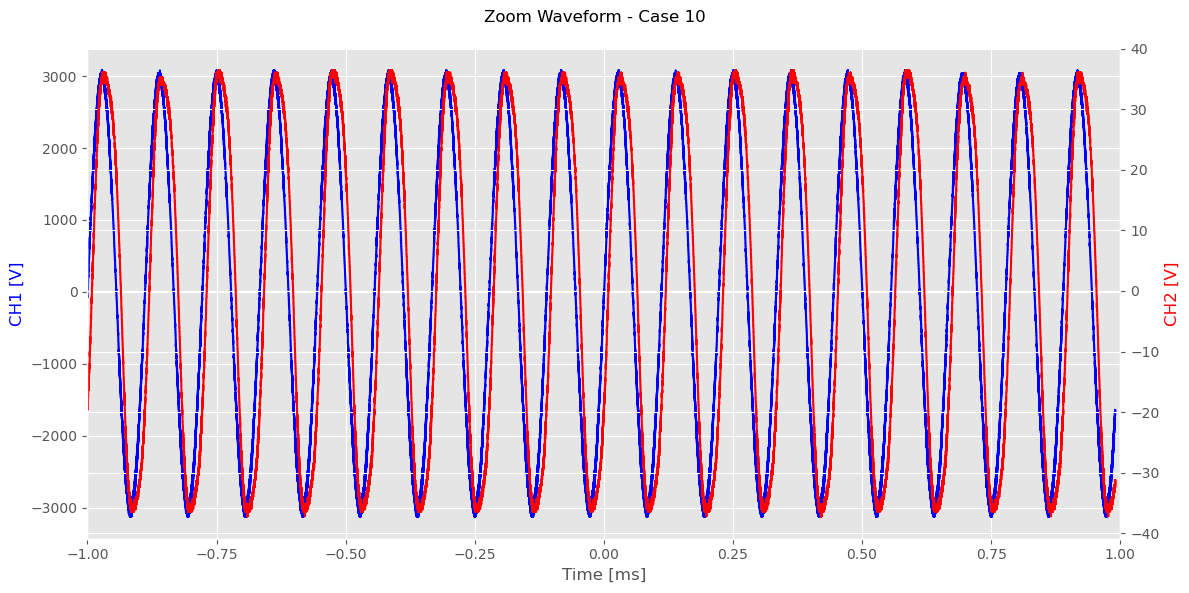

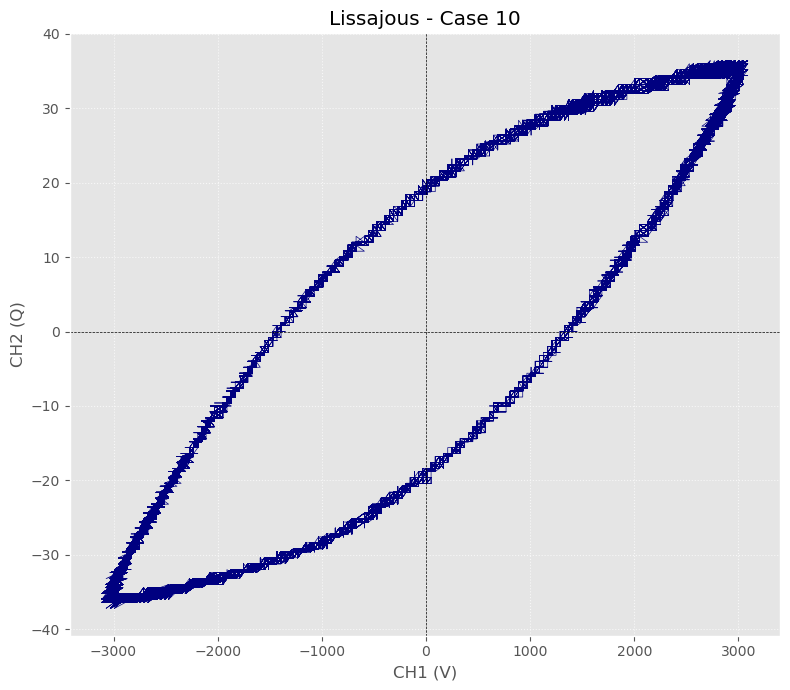

Case 10: Power = 4.7495 W, Area = 2878456.00 V^2


Case  Sampling Period     Vpp     Power  Power Density          Area
0     6     2.000000e-09  2120.0  0.176735       1.801578  1.071120e+05
1     7     2.000000e-09  3040.0  0.611609       6.234544  3.706720e+05
2     8     2.000000e-09  4120.0  1.531028      15.606813  9.278960e+05
3     9     2.000000e-09  5160.0  2.701010      27.533235  1.636976e+06
4    10     2.000000e-09  6200.0  4.749452      48.414398  2.878456e+06

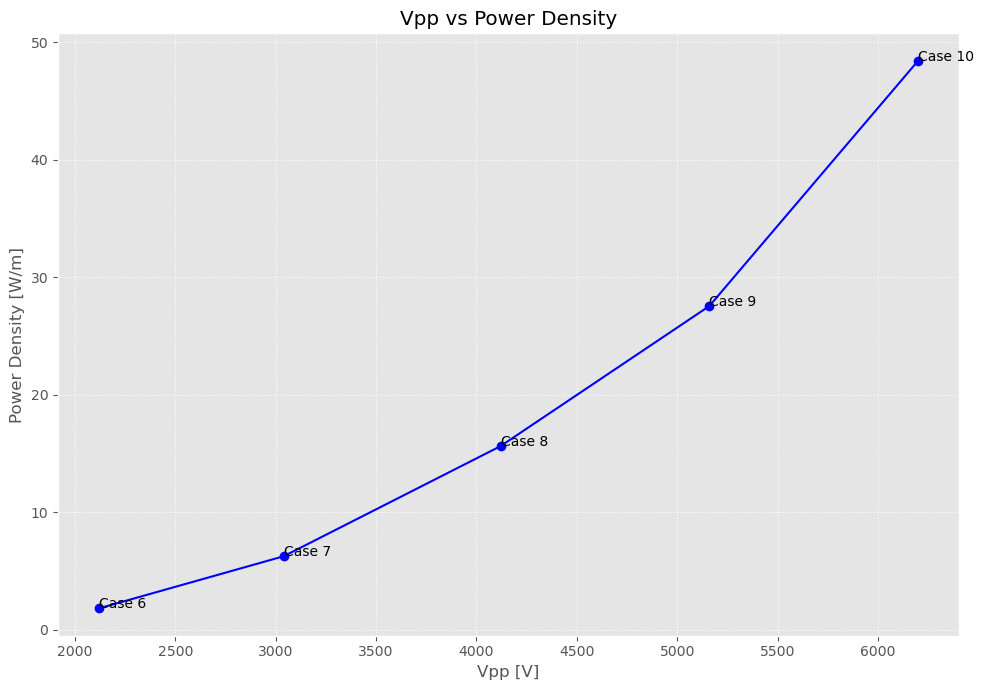

Fit: P = 1.5741e-10 * V^3.0332, R2 = 0.9958


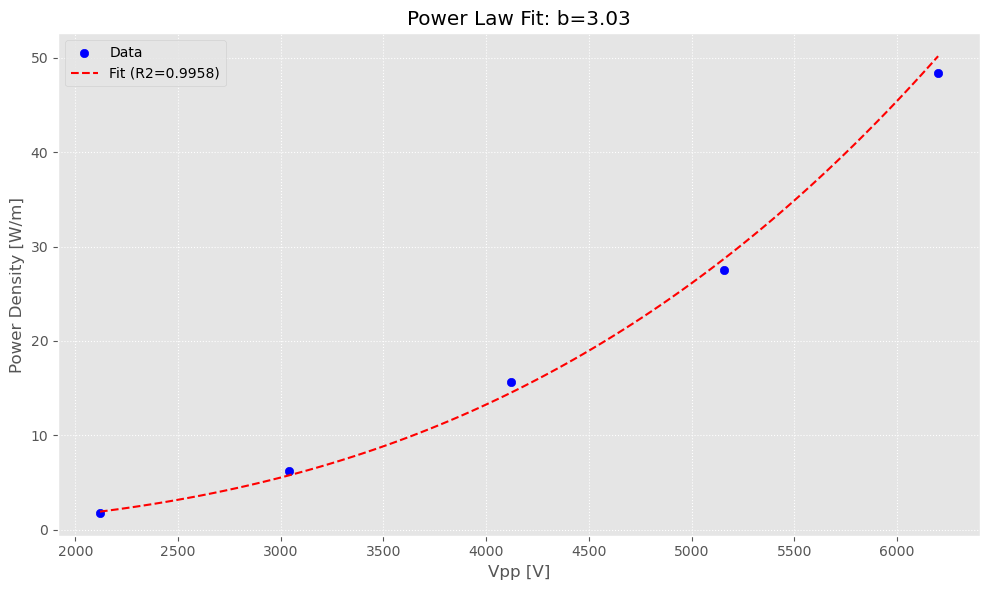

In [60]:
df_6_10 = analyze_cases([6,7,8,9,10], OUTPUT_DIR, C_m_Farad, device_length_meters)
display(df_6_10)
plot_power_vs_voltage(df_6_10, OUTPUT_DIR)
perform_power_law_fit(df_6_10, OUTPUT_DIR)